In [1]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cupy as np_gpu
import math
from torch.utils.data import DataLoader
import time
import torch.nn as nn
from sklearn.metrics import ConfusionMatrixDisplay

# Random Seeds
np_gpu.random.seed(123456789)
np.random.seed(123456789)

plt.rcParams.update({'font.size': 8})
DRIVE = '/content/drive/MyDrive/Sem7/DL/A1/plots/' 

# 0. Common Functions

In [2]:
def plot_loss(trainLP, testLP, fileName):
    X_plot = [i * 200 for i in range(len(trainLP))]

    # For using CuPy uncomment these 2 lines
    if(type(trainLP[0]) == np_gpu._core.core.ndarray):
        trainLP, testLP = np_gpu.array(trainLP).get(), np_gpu.array(testLP).get()

    plt.plot(X_plot, trainLP)
    plt.plot(X_plot, testLP)
    plt.xlabel('No. of batches')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'])
    plt.savefig(DRIVE + fileName)

def get_accuracy(pred, truth):
    return np.sum(pred == truth) / pred.shape[0]

def confusion_mat(pred, truth, fileName):
    ConfusionMatrixDisplay.from_predictions(truth, pred)
    plt.savefig(DRIVE + fileName)

# 1. BackProp from scratch

### Loading dataset

In [3]:
def one_hot(x):
    np_arr = np.zeros(10)
    np_arr[x] = 1
    return np_arr

mnist_train = torchvision.datasets.MNIST(root = ".", train = True, download = True); nTrain = len(mnist_train)
mnist_test = torchvision.datasets.MNIST(root = ".", train = False, download = True); nTest = len(mnist_test)

X_train = np_gpu.array([np.array(mnist_train[i][0]).reshape(-1) / 255 * 2 - 1 for i in range(nTrain)])
Y_train = np_gpu.array([one_hot(mnist_train[i][1]) for i in range(nTrain)])

X_test = np_gpu.array([np.array(mnist_test[i][0]).reshape(-1) / 255 * 2 - 1 for i in range(nTest)])
Y_test = np_gpu.array([one_hot(mnist_test[i][1]) for i in range(nTest)])

### Functions

In [4]:
def ReLU(X):
    return np_gpu.maximum(0, X)
def ReLU_derivative(X):
    return (X >= 0) * 1.0

def Tanh(X):
    return np_gpu.tanh(X)
def Tanh_derivative(X):
    return 1 - np_gpu.square(np_gpu.tanh(X))

def sigmoid(X):
    return 1 / (1 + np_gpu.exp(-X))
def sigmoid_derivative(X):
    return sigmoid(X) * (1 - sigmoid(X))

def softmax(X):
    return np_gpu.exp(X) / np_gpu.sum(np_gpu.exp(X), axis = 0)

def applyAct(X):
    if(actFn == 'sigmoid'): return sigmoid(X)
    if(actFn == 'ReLU'): return ReLU(X)
    if(actFn == 'Tanh'): return Tanh(X)

def derivative_act(X):
    if(actFn == 'sigmoid'): return sigmoid_derivative(X)
    if(actFn == 'ReLU'): return ReLU_derivative(X)
    if(actFn == 'Tanh'): return Tanh_derivative(X)

def forward(X):
    A, Z = [X], [X]
    for i in range(1, nl):
        Z.append(W[i-1] @ A[i-1] + B[i-1])
        if i == nl - 1: A.append(softmax(Z[i])) # Last layer softmax
        else: A.append(applyAct(Z[i]))
    return A, Z

def backward(A, Z, Y):
    Delta = [None for i in range(nl)]
    Delta[nl-1] = -(Y - A[nl-1]) * (1/batchSize) # Last layer soft_max
    for l in range(nl-2, 0, -1):
        Delta[l] = (W[l].T @ Delta[l+1]) * derivative_act(Z[l])
    return Delta

def loss(A, Y):
    return -np_gpu.sum(Y * np_gpu.log(A[nl-1])) / A[nl-1].shape[1]

def M(i):
    return math.sqrt(6 / (layers[i] + layers[i+1]))

### Neural Network Configuration

In [5]:
layers = [784, 500, 250, 100, 10] # I/P, h1, h2, h3, O/P
nl = len(layers)
batchSize = 64
epochs = 15
learningRate = 0.01
actFn = 'sigmoid' # 'ReLU' / 'Tanh' / 'sigmoid'

### Training

In [7]:
trainLossProgress, testLossProgress = [], []
W = [(2 * np_gpu.random.random_sample((layers[i+1], layers[i])) - 1) * M(i) for i in range(nl-1)]
B = [np_gpu.zeros((layers[i+1], 1)) for i in range(nl-1)]

startTime = time.time()
for epoch_id in range(epochs):
    id = 0

    startTimeEpoch = time.time()
    while(id + batchSize <= nTrain):
        X_train_batch, Y_train_batch = X_train[id:id+batchSize, :], Y_train[id:id+batchSize, :]
        id += batchSize

        # Initialise gradients to zero
        gradW, gradB = [np_gpu.zeros(W[i].shape) for i in range(nl-1)], [np_gpu.zeros(B[i].shape) for i in range(nl-1)]

        # Forward and Backward pass
        A, Z = forward(X_train_batch.T)
        Delta = backward(A, Z, Y_train_batch.T)

        # Computer gradients using delts
        for l in range(len(layers) - 1):
            gradW[l] += Delta[l+1] @ A[l].T
            gradB[l] += np_gpu.sum(Delta[l+1], axis = 1).reshape(-1, 1)

        # Update Weights and Biases
        for l in range(len(layers) - 1):
            W[l] -= learningRate * gradW[l]
            B[l] -= learningRate * gradB[l]

        step_id = (id-1) // batchSize
        if(step_id % 200 == 0):
            A_train, _ = forward(X_train.T)
            A_test, _ = forward(X_test.T)
            trainLossProgress.append(loss(A_train, Y_train.T))
            testLossProgress.append(loss(A_test, Y_test.T))
            print(f'Epoch: [{epoch_id + 1} / {epochs}], Step: [{step_id}/{nTrain//64}], Train Loss: {trainLossProgress[-1]:.2f}, Test Loss: {testLossProgress[-1]:.2f}')

    print(f'Epoch {epoch_id + 1} took {format(time.time() - startTimeEpoch, ".2f")} seconds\n')

print('TRAINING DONE', format(time.time() - startTime, ".2f")+" seconds")

Epoch: [1 / 15], Step: [0/937], Train Loss: 2.37, Test Loss: 2.37
Epoch: [1 / 15], Step: [200/937], Train Loss: 2.30, Test Loss: 2.30
Epoch: [1 / 15], Step: [400/937], Train Loss: 2.29, Test Loss: 2.29
Epoch: [1 / 15], Step: [600/937], Train Loss: 2.28, Test Loss: 2.28
Epoch: [1 / 15], Step: [800/937], Train Loss: 2.28, Test Loss: 2.28
Epoch 1 took 4.62 seconds

Epoch: [2 / 15], Step: [0/937], Train Loss: 2.27, Test Loss: 2.27
Epoch: [2 / 15], Step: [200/937], Train Loss: 2.26, Test Loss: 2.26
Epoch: [2 / 15], Step: [400/937], Train Loss: 2.25, Test Loss: 2.25
Epoch: [2 / 15], Step: [600/937], Train Loss: 2.24, Test Loss: 2.24
Epoch: [2 / 15], Step: [800/937], Train Loss: 2.23, Test Loss: 2.23
Epoch 2 took 4.46 seconds

Epoch: [3 / 15], Step: [0/937], Train Loss: 2.22, Test Loss: 2.22
Epoch: [3 / 15], Step: [200/937], Train Loss: 2.20, Test Loss: 2.20
Epoch: [3 / 15], Step: [400/937], Train Loss: 2.18, Test Loss: 2.18
Epoch: [3 / 15], Step: [600/937], Train Loss: 2.15, Test Loss: 2.15


### Testing

Test Accuracy: 88.62
Train Accuracy: 88.39666666666666


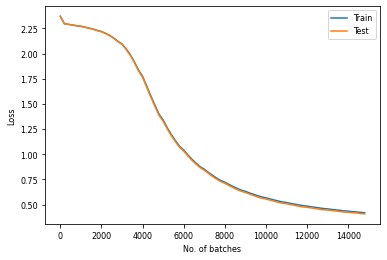

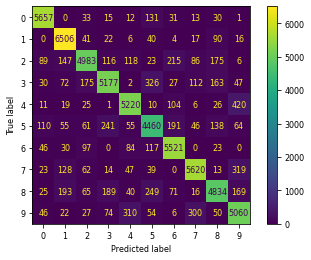

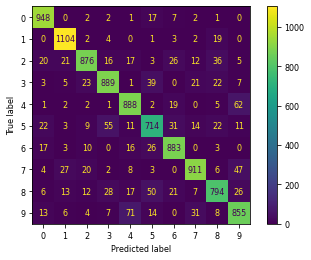

In [8]:
A, _ = forward(X_test.T)
pred_test, truth_test = np_gpu.argmax(A[nl-1], axis = 0).reshape(-1), np_gpu.argmax(Y_test.T, axis = 0).reshape(-1)

A, _ = forward(X_train.T)
pred_train, truth_train = np_gpu.argmax(A[nl-1], axis = 0).reshape(-1), np_gpu.argmax(Y_train.T, axis = 0).reshape(-1)

print('Test Accuracy:', get_accuracy(pred_test.get(), truth_test.get()) * 100)
print('Train Accuracy:', get_accuracy(pred_train.get(), truth_train.get()) * 100)

prefix = 'scratch_' + actFn

plot_loss(trainLossProgress, testLossProgress, prefix + '_loss.svg')

confusion_mat(pred_train.get(), truth_train.get(), prefix + '_cmat_train.svg')
confusion_mat(pred_test.get(), truth_test.get(), prefix + '_cmat_test.svg')

# 2. Using PyTorch

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Loading

In [10]:
mnist_train = torchvision.datasets.MNIST(root = ".", train = True, download = True, transform=transforms.ToTensor()); nTrain = len(mnist_train)
mnist_test = torchvision.datasets.MNIST(root = ".", train = False, download = True, transform=transforms.ToTensor()); nTest = len(mnist_test)

train_loader = DataLoader(mnist_train, batch_size=batchSize, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=batchSize, shuffle=False)

train_loader_1 = DataLoader(mnist_train, batch_size=len(mnist_train), shuffle=False)
X_train, Y_train = next(iter(train_loader_1))
X_train = X_train.reshape(-1, 784).to(device)
Y_train = Y_train.to(device)

test_loader_1 = DataLoader(mnist_test, batch_size=len(mnist_test), shuffle=False)
X_test, Y_test = next(iter(test_loader_1))
X_test = X_test.reshape(-1, 784).to(device)
Y_test = Y_test.to(device)

### Model Configuration

In [11]:
layers = [784, 500, 250, 100, 10] # I/P, h1, h2, h3, O/P
nl = len(layers)
batchSize = 64
epochs = 5
learningRate = 0.001
actFn = 'ReLU' # 'ReLU' / 'Tanh' / 'sigmoid'
weightDecay = 1e-4 # For L2 Regularisation, 0 if you don't want L2 regularisation

In [12]:
modelList = []
for i in range(nl-1):
    modelList.append(nn.Linear(layers[i], layers[i+1]))
    if(i == nl-2):
        modelList.append(nn.Softmax(1))
    else:
        if actFn == 'ReLU': modelList.append(nn.ReLU())
        if actFn == 'sigmoid': modelList.append(nn.Sigmoid())
        if actFn == 'Tanh': modelList.append(nn.Tanh())

In [13]:
model = nn.Sequential(*modelList).to(device)
lossFunction = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=weightDecay)

### Training

In [14]:
trainLossProgress = []
testLossProgress = []

startTime = time.time()
for epoch_id in range(epochs):
    startTimeEpoch = time.time()
    for step_id, (X_train_batch, Y_train_batch) in enumerate(train_loader):
        X_train_batch = X_train_batch.reshape(-1,784).to(device)
        Y_pred_batch = model(X_train_batch)
        loss = lossFunction(Y_pred_batch, Y_train_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if(step_id % 200 == 0):
            with torch.no_grad():
                trainLossProgress.append(lossFunction(model(X_train), Y_train).item())
                testLossProgress.append(lossFunction(model(X_test), Y_test).item())
                print(f'Epoch: [{epoch_id + 1} / {epochs}], Step: [{step_id}/{nTrain//64}], Train Loss: {trainLossProgress[-1]:.2f}, Test Loss: {testLossProgress[-1]:.2f}')
    print(f'Epoch {epoch_id + 1} took {format(time.time() - startTimeEpoch, ".2f")} seconds\n')

print('TRAINING DONE', format(time.time() - startTime, ".2f")+" seconds")

Epoch: [1 / 5], Step: [0/937], Train Loss: 2.30, Test Loss: 2.30
Epoch: [1 / 5], Step: [200/937], Train Loss: 1.70, Test Loss: 1.69
Epoch: [1 / 5], Step: [400/937], Train Loss: 1.63, Test Loss: 1.63
Epoch: [1 / 5], Step: [600/937], Train Loss: 1.59, Test Loss: 1.59
Epoch: [1 / 5], Step: [800/937], Train Loss: 1.57, Test Loss: 1.57
Epoch 1 took 6.77 seconds

Epoch: [2 / 5], Step: [0/937], Train Loss: 1.54, Test Loss: 1.54
Epoch: [2 / 5], Step: [200/937], Train Loss: 1.52, Test Loss: 1.52
Epoch: [2 / 5], Step: [400/937], Train Loss: 1.51, Test Loss: 1.52
Epoch: [2 / 5], Step: [600/937], Train Loss: 1.51, Test Loss: 1.51
Epoch: [2 / 5], Step: [800/937], Train Loss: 1.53, Test Loss: 1.53
Epoch 2 took 6.74 seconds

Epoch: [3 / 5], Step: [0/937], Train Loss: 1.52, Test Loss: 1.52
Epoch: [3 / 5], Step: [200/937], Train Loss: 1.50, Test Loss: 1.50
Epoch: [3 / 5], Step: [400/937], Train Loss: 1.50, Test Loss: 1.50
Epoch: [3 / 5], Step: [600/937], Train Loss: 1.50, Test Loss: 1.50
Epoch: [3 / 5]

### Testing

Test Accuracy: 96.83
Train Accuracy: 97.07833333333333


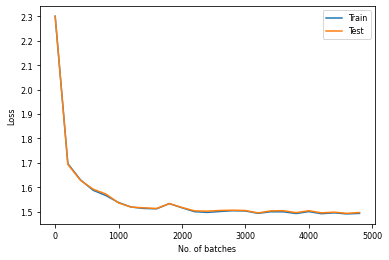

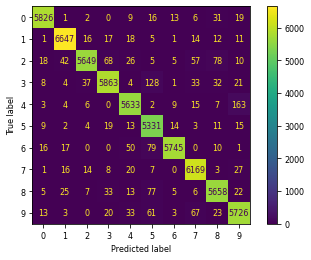

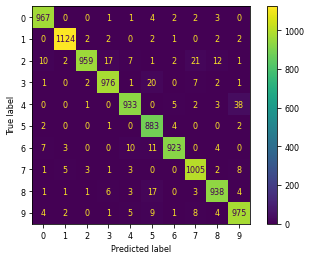

In [15]:
 with torch.no_grad():
    _, pred_test = torch.max(model(X_test), 1)
    pred_test = pred_test.to(torch.device('cpu')).numpy()
    _, pred_train = torch.max(model(X_train), 1)
    pred_train = pred_train.to(torch.device('cpu')).numpy()

    truth_test = Y_test.to(torch.device('cpu')).numpy()
    truth_train = Y_train.to(torch.device('cpu')).numpy()

    print('Test Accuracy:', get_accuracy(pred_test, truth_test) * 100)
    print('Train Accuracy:', get_accuracy(pred_train, truth_train) * 100)

    prefix = 'pytorch_' + actFn + str(learningRate) + '_' + str(epochs) + '_' + str(weightDecay)

    plot_loss(trainLossProgress, testLossProgress, prefix + '_loss.svg')

    confusion_mat(pred_train, truth_train, prefix + '_cmat_train.svg')
    confusion_mat(pred_test, truth_test, prefix + '_cmat_test.svg')

# References

1. https://analyticsindiamag.com/guide-to-feed-forward-network-using-pytorch-with-mnist-dataset/

2. https://blog.paperspace.com/dataloaders-abstractions-pytorch/

3. https://towardsdatascience.com/build-a-simple-neural-network-using-pytorch-38c55158028d